In [1]:
import cv2
import numpy as np
#import pytesseract
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import easyocr
import imutils
import pandas as pd
import csv
import time
from datetime import datetime

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

# CLICK PLATE PICTURES

In [3]:
frameWidth = 640
frameHeight = 480
plateCascade = cv2.CascadeClassifier("haarcascade_russian_plate_number.xml")
minArea = 500
color = (255,0,255)
count = 0

In [4]:
def getwebcam(args):    
    global count
    cap = cv2.VideoCapture(0)
    cap.set(3,frameWidth)
    cap.set(4, frameHeight)
    cap.set(10,150)
    while True:
        success, img = cap.read()
        #img = cv2.flip(img, 1)
        imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        numberPlates = plateCascade.detectMultiScale(imgGray, 1.1, 4)

        for (x,y,w,h) in numberPlates:

            area = w*h
            if area > minArea:
                cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,255), 2)
                cv2.putText(img, "number plate", (x,y-5), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2)
                imgROI =img[y:y+h, x:x+w]
                cv2.imshow("frame", imgROI)

        cv2.imshow("Result", img)

        if cv2.waitKey(1) == ord('s'):
            cv2.imwrite("PlateImages/NoPlate"+str(count)+".jpg", imgROI)
            cv2.rectangle(img,(0,200),(640,300),(0,255,0),cv2.FILLED)
            cv2.putText(img, "scanned ",(150,265),cv2.FONT_HERSHEY_DUPLEX, 2, (0,0,255), 2)
            count  = count + 1
            cv2.imshow("result",img)
            cv2.waitKey(5)
        if cv2.waitKey(1) == ord('q'):
            break
    cv2.destroyAllWindows()
    cap.release()

button_download = widgets.Button(description = 'Detect Plate !!', button_style='danger')  
button_download.on_click(getwebcam)
display(button_download)

Button(button_style='danger', description='Detect Plate !!', style=ButtonStyle())

# READ TEXT FROM PLATE

In [5]:
def returnlocation(locations):
    global tolllocation
    tolllocation = locations
    print(tolllocation)
    
interact(returnlocation, locations=['location1','location2']);

interactive(children=(Dropdown(description='locations', options=('Dahisar', 'Mulund'), value='Dahisar'), Outpu…

In [6]:
tolllocation

'Dahisar'

In [15]:
img = cv2.imread("PlateImages/ford.jpg")
#img = cv2.imread("PlateImages/NoPlate"+str(count)+".jpg")

Button(button_style='danger', description='Read Plate !!', style=ButtonStyle())

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


cropped method: 
[([[0, 2], [107, 2], [107, 31], [0, 31]], 'gBJY.9B2', 0.11823538690805435)]
number plate text: gBJY.9B2


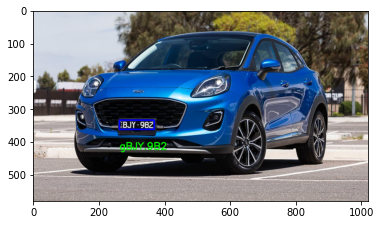

In [16]:
def readplate(args):    
    
    imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bifilter = cv2.bilateralFilter(imggray, 11,17,17)
    edge = cv2.Canny(bifilter, 30, 200)
    points = cv2.findContours(edge.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours =  imutils.grab_contours(points)
    contours = sorted(contours, key= cv2.contourArea, reverse = True)[:10]

    loc = None
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 10, True)
        if len(approx) == 4:
            loc = approx
            break

    mask = np.zeros(imggray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [loc], 0,255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)

    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = imggray[x1:x2+1, y1:y2+1]

    reader = easyocr.Reader(['en'])
    result1 = reader.readtext(cropped_image)
    print("cropped method: ")
    print(result1)


    text = result1[0][-2]
    print("number plate text: "+text)
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (255,0,0),3)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

    now = datetime.now()
    today = now.strftime("%d %B,%Y : %H:%M")

    df  = pd.read_csv(str(tolllocation)+'.csv')
    df = df.append({'PlateNumber' : text , 'datetime' : today} , ignore_index=True)
    df.to_csv(str(tolllocation)+'.csv', index=False)

    
button_download = widgets.Button(description = 'Read Plate !!', button_style='danger')  
button_download.on_click(readplate)
display(button_download)